# **FINE TUNING FASTER RCNN USING PYTORCH**

6 os

In this Notebook we can fine tune a Faster RCNN on the images dataset. If you want to brush up about what is Faster RCNN, [here's](https://medium.com/@whatdhack/a-deeper-look-at-how-faster-rcnn-works-84081284e1cd) an awesome medium article on the same.

Ref: inspired by the Pytorch docs tutorial [here](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)


## Installs and Imports

Since a lot of code for object detection is same and has to be rewritten by everyone, torchvision contributers have provided us with helper codes for training, evaluation and transformations.

Let's clone the repo and copy the libraries into working directory

In [1]:
# Download TorchVision repo to use some files from references/detection
# !git clone https://github.com/pytorch/vision.git
# !git checkout v0.3.0
# !cp vision/references/detection/utils.py ./
# !cp vision/references/detection/transforms.py ./
# !cp vision/references/detection/coco_eval.py ./
# !cp vision/references/detection/engine.py ./
# !cp vision/references/detection/coco_utils.py ./

In [2]:
# %%bash
# apt update
# DEBIAN_FRONTEND=noninteractive apt-get install -y python3-opencv
# #tz prompt. dpkg fix...
# pip install opencv-python
# #pip install cv2

In [3]:
# !pip install pycocotools 

In [4]:
pip list

Package                 Version
----------------------- ---------
absl-py                 1.0.0
albumentations          1.1.0
argcomplete             1.12.3
argon2-cffi             21.1.0
attrs                   21.2.0
backcall                0.2.0
beautifulsoup4          4.10.0
bleach                  4.1.0
blis                    0.7.5
boto3                   1.20.4
botocore                1.23.4
bravado                 11.0.3
bravado-core            5.17.0
brotlipy                0.7.0
cachetools              4.2.4
captum                  0.4.1
catalogue               2.0.6
catalyst                21.10
certifi                 2021.10.8
cffi                    1.14.6
chardet                 4.0.0
click                   8.0.3
conda                   4.10.3
conda-build             3.21.5
conda-package-handling  1.7.3
configparser            5.1.0
cryptography            3.4.8
cycler                  0.11.0
cymem                   2.0.6
debugpy                 1.5.1
decorator         

In [5]:
conda list

# packages in environment at /opt/conda:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                        main  
_openmp_mutex             4.5                       1_gnu  
absl-py                   1.0.0                    pypi_0    pypi
albumentations            1.1.0                    pypi_0    pypi
argcomplete               1.12.3                   pypi_0    pypi
argon2-cffi               21.1.0                   pypi_0    pypi
attrs                     21.2.0                   pypi_0    pypi
backcall                  0.2.0              pyhd3eb1b0_0  
beautifulsoup4            4.10.0             pyh06a4308_0  
blas                      1.0                         mkl  
bleach                    4.1.0                    pypi_0    pypi
blis                      0.7.5                    pypi_0    pypi
boto3                     1.20.4                   pypi_0    pypi
botocore                  1.23.4                   pypi_0    p


Note: you may need to restart the kernel to use updated packages.


Lets import the libraries

In [6]:
# Basic python and ML Libraries
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# We will be reading images using OpenCV
import cv2
from PIL import Image

# xml library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
from torchvision import transforms as torchtrans  
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# these are the helper libraries imported.
from engine import train_one_epoch, evaluate
import utils
import transforms as T

# for image augmentations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2


In [7]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |       0 B  |
|       from small pool |       0 B  |       0 B  |       0 B  |       0 B  |
|---------------------------------------------------------------------------|
| Active memory         |       0 B  |       0 B  |       0 B  |       0 B  |
|       from large pool |       0 B  |       0 B  |       0 B  |

## Dataset 

In [25]:
# Settings:

!pwd

files_dir = '../imgdata/6out01/trainval/'
test_dir = '../imgdata/6out01/test/'

setwidth = 500
#setheight = 7990 actual give assertionerror. 7500 works.
setheight = 7900

num_classes = 3

test_split = 0.7

num_epochs = 16

# edit these in the code below...

img_file_suffix = 'edit below'

setclasses = "edit below  self.classes = [_, 'Chip']"


/notebooks/ml635e2/ml635j


# Inspect one image..

In [26]:
imgs = [image for image in sorted(os.listdir(files_dir))
                    if image[-4:]=='.png']

img_name = imgs[1]
image_path = os.path.join(files_dir, img_name)

# reading the images and converting them to correct size and color    
img = cv2.imread(image_path)
imgp = Image.open(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
#img_res = cv2.resize(img_rgb, (width, height), cv2.INTER_AREA)
# diving by 255
# img_res /= 255.0

print( img.shape)
print( imgp.format)
print( image_path)


(7990, 500, 3)
PNG
../imgdata/6out01/trainval/outer_surface_210804T142702.png


Lets build the images dataset

In [27]:
# defining the files directory and testing directory
# files_dir = '../cast04c/train'
# test_dir = '../cast04c/test'
# files_dir = '../imgdata/sg/s1out/train/'
# test_dir = '../imgdata/sg/s1out/test/'


class AaImagesDataset(torch.utils.data.Dataset):

    def __init__(self, files_dir, width, height, transforms=None):
        self.transforms = transforms
        self.files_dir = files_dir
        self.height = height
        self.width = width
        
        # sorting the images for consistency
        # To get images, the extension of the filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(files_dir))
                        if image[-4:]=='.png']
        
        # classes: 0 index is reserved for background
        self.classes = [_, 'Chip', 'Crack']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.files_dir, img_name)

        # reading the images and converting them to correct size and color    
        img = cv2.imread(image_path)
        imgp = Image.open(image_path)
        #print(idx, imgp.format)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        # diving by 255
        img_res /= 255.0
        
        # annotation file
        annot_filename = img_name[:-4] + '.xml'
        annot_file_path = os.path.join(self.files_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # cv2 image gives size as height x width
        wt = img.shape[1]
        ht = img.shape[0]
        
        # box coordinates for xml files are extracted and corrected for image size given
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        # image_id
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            sample = self.transforms(image = img_res,
                                     bboxes = target['boxes'],
                                     labels = labels)
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
                       
        return img_res, target

    def __len__(self):
        return len(self.imgs)


In [28]:

# check dataset
dataset = AaImagesDataset(files_dir, setwidth, setheight)
print('length of dataset = ', len(dataset), '\n')
dsetlen = len(dataset)

# getting the image and target for a test index.  Feel free to change the index.
img, target = dataset[0]
print(img.shape, '\n',target)

length of dataset =  79 

(7900, 500, 3) 
 {'boxes': tensor([[ 137.0000, 2919.7371,  159.0000, 3167.9099]]), 'labels': tensor([2]), 'area': tensor([5459.8027]), 'iscrowd': tensor([0]), 'image_id': tensor([0])}


Points to be noted -
1. The dataset returns a tuple. The first element is the image shape and the second element is a dictionary.
2. The image is of the size, we provided while defining the dataset and the color mode is RGB.
3. There are four bounding boxes in the image which is evident from four lists in boxes and length of labels.

And its done! 

Dataset building is one of the hardest things in the notebook. If you got till here while understand all of the above, you are doing pretty good!

Let's now see, what our data looks like. The function is inspired from [here](https://www.kaggle.com/kiwifairy/visualize-x-ray-image-with-bounding-boxes)

# Dataset Visualization

tensor([ 307.0000, 6735.2690,  332.0000, 6897.4219])


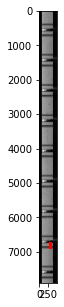

img: [[[0.01176471 0.01176471 0.01176471]
  [0.01178704 0.01178704 0.01178704]
  [0.01178704 0.01178704 0.01178704]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01561926 0.01561926 0.01561926]
  [0.01568628 0.01568628 0.01568628]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.0118764  0.0118764  0.0118764 ]
  [0.01557458 0.01557458 0.01557458]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 ...

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  ...
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176471]]

 [[0.01176471 0.01176471 0.01176471]
  [0.01176471 0.01176471 0.01176

In [29]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img)
    for box in ((target['boxes']).cpu()):
        print(box)
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = dataset[1]
plot_img_bbox(img, target)
print("img:",img,"targ:",target)

You can see that we are doing great till now, as the bbox is correctly placed. 

Lets build the model then!

# Prep Model

We will define a function for loading the model. We will call it later

In [30]:

def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

You can clearly see, how easy it is to load and prepare the model using pytorch

# Dataset Augmentations

This is where we can apply augmentations to the image. 

The augmentations to object detection vary from normal augmentations becuase here we need to ensure that, bbox still aligns with the object correctly after transforming.

Here I have added random flip transform, feel free to customize it as you feel



In [31]:
# Send train=True fro training transforms and False for val/test transforms
def get_transform(train):
    
    if train:
        return A.Compose([
                            A.HorizontalFlip(0.5),
                     # ToTensorV2 converts image to pytorch tensor without div by 255
                            ToTensorV2(p=1.0) 
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            ToTensorV2(p=1.0)
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

# Preparing dataset

Now lets prepare datasets and dataloaders for training and testing.

In [32]:
# use our dataset and defined transformations
dataset = AaImagesDataset(files_dir,  setwidth, setheight, transforms= get_transform(train=True))
dataset_test = AaImagesDataset(files_dir, setwidth, setheight, transforms= get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
# test_split = 0.5
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=10, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=10, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

# Training

Let's prepare the model for training

In [50]:
# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

# num_classes = 2

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda


Let the training begin!

In [34]:
# !export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128

# Run the training.......

In [35]:
# training for 10 epochs

# edit me..
#num_epochs = 3

!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128
torch.cuda.empty_cache()
    
for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)
    
print('reached.end.')

Epoch: [0]  [0/3]  eta: 0:00:33  lr: 0.002502  loss: 2.1728 (2.1728)  loss_classifier: 1.0409 (1.0409)  loss_box_reg: 0.0049 (0.0049)  loss_objectness: 0.9057 (0.9057)  loss_rpn_box_reg: 0.2213 (0.2213)  time: 11.0052  data: 9.7503  max mem: 2563
Epoch: [0]  [2/3]  eta: 0:00:04  lr: 0.005000  loss: 1.3200 (1.2413)  loss_classifier: 1.0374 (0.7435)  loss_box_reg: 0.0097 (0.0105)  loss_objectness: 0.2412 (0.4017)  loss_rpn_box_reg: 0.0316 (0.0856)  time: 4.1125  data: 3.3337  max mem: 2563
Epoch: [0] Total time: 0:00:12 (4.1464 s / it)
creating index...
index created!
Test:  [0/6]  eta: 0:00:57  model_time: 0.3396 (0.3396)  evaluator_time: 0.0079 (0.0079)  time: 9.5526  data: 9.0377  max mem: 2563
Test:  [5/6]  eta: 0:00:02  model_time: 0.3376 (0.3089)  evaluator_time: 0.0079 (0.0081)  time: 2.4454  data: 1.9868  max mem: 2563
Test: Total time: 0:00:14 (2.4636 s / it)
Averaged stats: model_time: 0.3376 (0.3089)  evaluator_time: 0.0079 (0.0081)
Accumulating evaluation results...
DONE (t=0

creating index...
index created!
Test:  [0/6]  eta: 0:01:01  model_time: 0.4171 (0.4171)  evaluator_time: 0.0145 (0.0145)  time: 10.1958  data: 9.5373  max mem: 2563
Test:  [5/6]  eta: 0:00:02  model_time: 0.3403 (0.3267)  evaluator_time: 0.0044 (0.0064)  time: 2.6912  data: 2.1922  max mem: 2563
Test: Total time: 0:00:16 (2.7081 s / it)
Averaged stats: model_time: 0.3403 (0.3267)  evaluator_time: 0.0044 (0.0064)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.5

Epoch: [9]  [0/3]  eta: 0:00:31  lr: 0.000005  loss: 0.3513 (0.3513)  loss_classifier: 0.0949 (0.0949)  loss_box_reg: 0.0262 (0.0262)  loss_objectness: 0.0926 (0.0926)  loss_rpn_box_reg: 0.1376 (0.1376)  time: 10.4902  data: 9.7429  max mem: 2563
Epoch: [9]  [2/3]  eta: 0:00:03  lr: 0.000005  loss: 0.2233 (0.2562)  loss_classifier: 0.0949 (0.0972)  loss_box_reg: 0.0262 (0.0271)  loss_objectness: 0.0576 (0.0669)  loss_rpn_box_reg: 0.0330 (0.0651)  time: 3.9255  data: 3.3082  max mem: 2563
Epoch: [9] Total time: 0:00:11 (3.9674 s / it)
creating index...
index created!
Test:  [0/6]  eta: 0:01:02  model_time: 0.3386 (0.3386)  evaluator_time: 0.0121 (0.0121)  time: 10.4222  data: 9.8863  max mem: 2563
Test:  [5/6]  eta: 0:00:02  model_time: 0.3341 (0.3081)  evaluator_time: 0.0050 (0.0069)  time: 2.7330  data: 2.2503  max mem: 2563
Test: Total time: 0:00:16 (2.7523 s / it)
Averaged stats: model_time: 0.3341 (0.3081)  evaluator_time: 0.0050 (0.0069)
Accumulating evaluation results...
DONE (t=

Epoch: [13]  [2/3]  eta: 0:00:04  lr: 0.000001  loss: 0.1943 (0.3425)  loss_classifier: 0.0991 (0.1114)  loss_box_reg: 0.0250 (0.0298)  loss_objectness: 0.0581 (0.0847)  loss_rpn_box_reg: 0.0334 (0.1166)  time: 4.1903  data: 3.5816  max mem: 2563
Epoch: [13] Total time: 0:00:12 (4.2309 s / it)
creating index...
index created!
Test:  [0/6]  eta: 0:01:05  model_time: 0.3678 (0.3678)  evaluator_time: 0.0087 (0.0087)  time: 10.8462  data: 10.2734  max mem: 2563
Test:  [5/6]  eta: 0:00:02  model_time: 0.3191 (0.3089)  evaluator_time: 0.0047 (0.0059)  time: 2.6775  data: 2.2165  max mem: 2563
Test: Total time: 0:00:16 (2.6932 s / it)
Averaged stats: model_time: 0.3191 (0.3089)  evaluator_time: 0.0047 (0.0059)
Accumulating evaluation results...
DONE (t=0.01s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | m


# Comments

An AP of 0.78-0.80 is not bad but perhaps we can make it even better with more augmentations, I will leave that to you.

# Decode predictions

Our model predicts a lot of bounding boxes per image, to take out the overlapping ones, We will use **Non Max Suppression** if you want to brush up on that, check [this](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) out.

Torchvision provides us a utility to apply nms to our predictions, lets build a function `apply_nms` using that.

In [61]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.05):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB')

# Testing our Generated/trained Model

Lets take an image from our test dataset and see, how our model does.

We will first see, how many bounding boxes does our model predict compared to actual

In [62]:
print('length of dataset = ', len(dataset), '\n')

length of dataset =  24 



In [63]:
# pick one image from the test set

for x in range(6):
    print(x)

    img, target = dataset_test[x]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])[0]

    print('predicted #boxes: ', len(prediction['labels']))
    print('real #boxes: ', len(target['labels']))

0
predicted #boxes:  100
real #boxes:  1
1
predicted #boxes:  100
real #boxes:  2
2
predicted #boxes:  100
real #boxes:  1
3
predicted #boxes:  100
real #boxes:  1
4
predicted #boxes:  100
real #boxes:  1
5
predicted #boxes:  100
real #boxes:  1


Whoa! Thats a lot of bboxes. Lets plot them and check what did it predict

EXPECTED OUTPUT
tensor([ 125.0000, 4508.6357,  144.0000, 4613.4419])


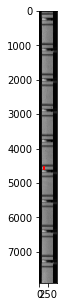

In [64]:
print('EXPECTED OUTPUT')
plot_img_bbox(torch_to_pil(img), target)

MODEL OUTPUT
tensor([  32.0952, 5274.9976,  456.3183, 5621.5571])
tensor([  66.9985, 5415.7007,  412.6343, 5540.6870])
tensor([  34.5239, 1056.7562,  402.3418, 1170.1681])
tensor([  22.6073,  871.5708,  449.6874, 1194.8074])
tensor([  33.6316, 2623.4109,  444.5227, 2963.6025])
tensor([5.7890e-01, 1.0122e+03, 5.0000e+02, 1.2385e+03])
tensor([  36.2602, 6969.1411,  417.9304, 7317.4927])
tensor([   0.0000,  831.2684,  396.5057, 1508.8933])
tensor([  11.9812, 6372.1470,  493.6648, 7069.3291])
tensor([   0.0000, 6746.9849,  500.0000, 7212.9531])
tensor([ 198.7996, 6869.5889,  500.0000, 7340.9077])
tensor([  51.2359, 2721.2415,  395.8224, 2859.2068])
tensor([  44.9336, 7118.4800,  374.6635, 7247.1582])
tensor([ 391.1099, 7868.5278,  497.7140, 7899.0386])
tensor([   0.0000, 2601.8071,  422.4249, 3350.1143])
tensor([   0.0000, 7140.2480,  500.0000, 7360.3843])
tensor([   0.0000, 5044.8691,  454.7980, 5829.1606])
tensor([  13.8475, 1711.4087,  440.2580, 2061.9683])
tensor([   0.0000,  383.0105,

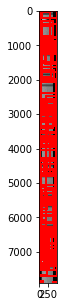

In [65]:
print('MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), prediction)

You can see that our model predicts a lot of bounding boxes for every apple. Lets apply nms to it and see the final output

NMS APPLIED MODEL OUTPUT
tensor([  32.0952, 5274.9976,  456.3183, 5621.5571])
tensor([  34.5239, 1056.7562,  402.3418, 1170.1681])
tensor([  33.6316, 2623.4109,  444.5227, 2963.6025])
tensor([  36.2602, 6969.1411,  417.9304, 7317.4927])
tensor([ 391.1099, 7868.5278,  497.7140, 7899.0386])
tensor([  13.8475, 1711.4087,  440.2580, 2061.9683])
tensor([   0.0000, 5965.4248,  500.0000, 6940.7871])
tensor([  26.7704, 3545.3828,  499.5654, 4267.1328])
tensor([   0.0000, 7875.9814,   79.4782, 7900.0000])
tensor([  41.1001, 4432.8384,  500.0000, 5202.2544])
tensor([ 73.6930,   0.0000, 500.0000, 192.6482])
tensor([ 59.1767, 432.8001, 395.5587, 934.0840])


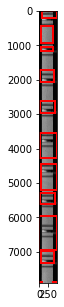

In [66]:
nms_prediction = apply_nms(prediction, iou_thresh=0.01)
print('NMS APPLIED MODEL OUTPUT')
plot_img_bbox(torch_to_pil(img), nms_prediction)

Now lets take an image from the test set and try to predict on it

EXPECTED OUTPUT

tensor([ 110.0000, 3895.6196,  193.0000, 4167.5220])


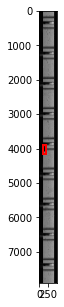

MODEL OUTPUT

tensor([   0.0000, 4517.4287,  312.7505, 4717.2017])
tensor([  79.4184, 3695.6404,  367.3309, 3828.8110])
tensor([  10.8460, 1012.5911,  500.0000, 1252.9791])
tensor([  50.7785, 5278.4297,  440.5219, 5632.2114])
tensor([  66.4889, 4724.6567,  416.5964, 4827.1846])
tensor([   7.7418, 6157.3633,  500.0000, 7033.3945])
tensor([  71.7031, 2604.4021,  463.3395, 2972.7332])
tensor([  54.7347, 1753.8412,  440.7200, 2118.4775])
tensor([   0.0000, 7858.0020,  123.3121, 7900.0000])
tensor([ 105.0779, 2977.7844,  433.4226, 3110.5793])
tensor([  65.3366, 7080.2568,  432.6912, 7398.1279])
tensor([115.8210, 338.8081, 447.4542, 455.5492])
tensor([ 491.0815, 7887.6196,  499.6886, 7900.0000])
tensor([0.0000e+00, 7.8855e+03, 2.4558e-01, 7.9000e+03])
tensor([  97.0104,  448.6576,  479.1101, 1002.3165])


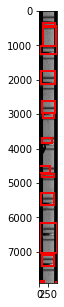

In [67]:
## !pwd
test_dataset = AaImagesDataset(test_dir,  setwidth, setheight, transforms= get_transform(train=True))
# pick one image from the test set
img, target = test_dataset[1]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('EXPECTED OUTPUT\n')
plot_img_bbox(torch_to_pil(img), target)
print('MODEL OUTPUT\n')
nms_prediction = apply_nms(prediction, iou_thresh=0.01)

plot_img_bbox(torch_to_pil(img), nms_prediction)

But fear not, this is just a base line model here are some ideas we can improve it - 
1. Use a better model. 
   We have the option of changing the backbone of our model which at present is `resnet 50` and the fine tune it.
2. We can change the training configurations like size of the images, optimizers and learning rate schedule.
3. We can add more augmentations.
   We have used the Albumentations library which has an extensive library of data augmentation functions. Feel free to explore and try them out. 

# Fin.

That's it for the notebook. 


In [75]:
%%bash
pwd
#mkdir -p ../savedmodel
#echo "savedmodel/" >> ../.gitignore
cat  ../.gitignore

/notebooks/ml635e2/ml635j
*.zip
*.pth
imgdata/
savedmodel/


In [76]:
torch.save(model, '../savedmodel/6os-2022-06-17a.pth')